# Class Diagrams

This is a simple viewer for class diagrams.  Customized towards the book.

**Prerequisites**

* _Refer to earlier chapters as notebooks here, as here:_ [Earlier Chapter](Fuzzer.ipynb).

In [1]:
import bookutils

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.ClassDiagram import <identifier>
```

and then make use of the following features.


The `display_class_hierarchy()` function shows the class hierarchy for the given class (or list of classes).  Methods with docstrings (intended to be used by the public) are shown in bold.

```python
>>> display_class_hierarchy(D)
```

![](PICS/ClassDiagram-synopsis-1.svg)



## Getting a Class Hierarchy

Using `mro()`, we can access the class hierarchy.  We make sure to avoid duplicates created by `class X(X)`.

In [2]:
def class_hierarchy(cls):
    superclasses = cls.mro()
    hierarchy = []
    last_superclass_name = ""
    for superclass in superclasses:
        if superclass.__name__ != last_superclass_name:
            hierarchy.append(superclass)
            last_superclass_name = superclass.__name__
    return hierarchy

Here's an example:

In [3]:
class A:
    def foo(self):
        pass

In [4]:
class B(A):
    def foo(self):
        pass
    def bar(self):
        pass

In [5]:
class C:
    def qux(self):
        pass

In [6]:
class D(B, C):
    def foo(self):
        B.foo(self)


In [7]:
class_hierarchy(A)

[__main__.A, object]

## Getting a Class Tree

We can use `__bases__` to obtain the immediate base classes.

In [8]:
D.__bases__

(__main__.B, __main__.C)

In [9]:
def class_tree(cls):
    ret = []
    for base in cls.__bases__:
        if base.__name__ == cls.__name__:
            ret += class_tree(base)
        else:
            ret.append((cls, class_tree(base)))
    return ret

In [10]:
def class_tree(cls):
    
    def base_tree(base):
        while base.__name__ == cls.__name__:
            base = base.__bases__[0]
        return class_tree(base)
    
    ret = []
    for base in cls.__bases__:
        ret.append((cls, base_tree(base)))
    return ret

In [11]:
class_tree(D)

[(__main__.D, [(__main__.B, [(__main__.A, [])])]),
 (__main__.D, [(__main__.C, [])])]

Not perfect yet (multiple instances of same class), but we're getting there.

## Getting methods

In [12]:
import inspect

In [13]:
def class_methods(cls):
    def _class_methods(cls):
        all_methods = inspect.getmembers(cls, lambda m: inspect.isfunction(m))
        for base in cls.__bases__:
            all_methods += _class_methods(base)
        return all_methods

    unique_methods = []
    methods_seen = set()
    for (name, fun) in _class_methods(cls):
        if name not in methods_seen:
            unique_methods.append((name, fun))
            methods_seen.add(name)

    return unique_methods

In [14]:
class_methods(D)

[('bar', <function __main__.B.bar(self)>),
 ('foo', <function __main__.D.foo(self)>),
 ('qux', <function __main__.C.qux(self)>)]

We're only interested in 

* functions _defined_ in that class
* functions that come with a docstring

In [15]:
def public_class_methods(cls):
    return [(name, method) for (name, method) in class_methods(cls) if method.__qualname__.startswith(cls.__name__)]

In [16]:
def doc_class_methods(cls):
    return [(name, method) for (name, method) in public_class_methods(cls) if method.__doc__ is not None]

In [17]:
public_class_methods(D)

[('foo', <function __main__.D.foo(self)>)]

In [18]:
doc_class_methods(D)

[]

## Drawing Class Hierarchy with Method Names

In [19]:
def display_class_hierarchy(classes, include_methods=True):
    from graphviz import Digraph
    
    CLASS_FONT = 'Patua One, Helvetica, sans-serif'
    METHOD_FONT = 'monospace'

    if isinstance(classes, list):
        starting_class = classes[0]
    else:
        starting_class = classes
        classes = [starting_class]

    dot = Digraph(comment=starting_class.__name__ + " hierarchy")
    dot.attr('node', shape='record', fontname=CLASS_FONT)
    dot.attr('graph', rankdir='BT')
    dot.attr('edge', arrowhead='empty')
    edges = set()

    def method_string(name, f):
        method_string = '<font face="' + METHOD_FONT + '" point-size="10">'
        if f.__doc__ is not None:
            method_string += '<b>' + name + '()</b>'
        else:
            method_string += '<font color="#808080">' + name + '()</font>'
        method_string += '</font>'
        return method_string

    def class_methods_string(cls):
        methods = public_class_methods(cls)
        # return "<br/>".join([name + "()" for (name, f) in methods])

        methods_string = '<table border="0" cellpadding="0" cellspacing="0" align="left">'
        for doc in [True, False]:
            for (name, f) in methods:
                if (doc and f.__doc__ is not None) or (not doc and f.__doc__ is None):
                    methods_string += '<tr><td align="left" border="0">'
                    methods_string += method_string(name, f)
                    methods_string += '</td></tr>'
        methods_string += '</table>'
        return methods_string

    def display_class_node(cls):
        name = cls.__name__
        url = cls.__module__ + '.ipynb'
        if include_methods:
            methods = class_methods_string(cls)
            spec = '<{<b><font color="#B03A2E">' + cls.__name__ + '</font></b>|' + methods + '}>'
        else:
            spec = '<' + cls.__name__ + '>'
        dot.node(name, spec, href=url)

    def display_class_tree(trees):
        for tree in trees:
            (cls, subtrees) = tree
            display_class_node(cls)
            for subtree in subtrees:
                (subcls, _) = subtree
                if (cls, subcls) not in edges:
                    dot.edge(cls.__name__, subcls.__name__)
                    edges.add((cls, subcls))
            display_class_tree(subtrees)

    for cls in classes:
        tree = class_tree(cls)
        display_class_tree(tree)

    return dot

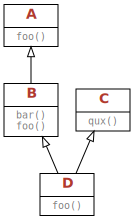

In [20]:
display_class_hierarchy([D, A])

## Synopsis

The `display_class_hierarchy()` function shows the class hierarchy for the given class (or list of classes).  Methods with docstrings (intended to be used by the public) are shown in bold.

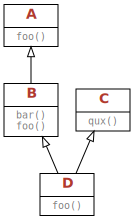

In [21]:
display_class_hierarchy(D)

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```markdown
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [22]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [23]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_